# Classification with Deep Neural Networks

## Load MNIST Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torchvision import datasets, transforms

이미지 전처리는 Compose클래스를 통해 통합적으로 이루어 지는데, <br>
그 안에서 사용된 ToTensor는 PIL형태의 이미지나 ndarray를 Pytorch가 이해할 수 있는 Tensor자료형으로 바꾸어 주는 역할을 한다.<br>
이처럼 전처리란, 엄밀히 말하자면 데이터셋을 적절한 자료구조로 바꾸는 부분까지도 포함해야 한다.
- PIL(Python Imaging Library) : 파이썬 인터프리터에 다양한 이미지 파일 형식을 지원하고 강력한 이미지 처리와 그래픽 기능을 제공하는 자유-오픈 소스 소프트웨어 라이브러리
    - Pillow라는 후속 프로젝트가 PIL저장소에서 갈라져 나와 Python 3.x지원을 추가 했다.


In [3]:
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

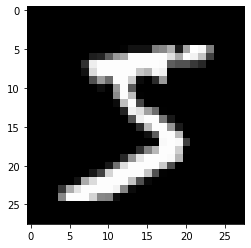

In [5]:
plot(train.data[0])

In [9]:
x = train.data.float() / 255. # min_max_scaler
y = train.targets

x = x.view(x.size(0), -1) # view : 원소의 수를 유지하면서 텐서의 크기 변경!!
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size: 784, output_size: 10


In [10]:
# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)] # view : 원소의 수를 유지하면서 텐서의 크기 변경!!
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

# y는 Long tensor, one-hot vector의 index를 가지고 있는 상태! (e.g. 3)

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


## Build Model & Optimizer

softmax 함수에서 exponentional을 사용하는 이유
1. e^x는 미분이 용이하여 gradient를 발생시켜 역전파 알고리즘을 적용하는 것에 좋다.
2. 입력 벡터가 더 잘 구분되게 하는 역할을 한다.
    - 큰 값은 더 크게, 작은 값은 더 작게, 이는 자연상수 지수함수의 그래프를 보면 알 수 있다.

In [11]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1), # 각 클래스별 (log) 확률 값 -> NLLLoss 사용!
)


model

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)

In [12]:
# 1. LogSoftmax -> NLLLoss 사용 (권장)
# 2. Softmax -> Cross_entropy 사용

crit = nn.NLLLoss()

In [13]:
optimizer = optim.Adam(model.parameters())

## Move to GPU if it is available

In [14]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [15]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

## Train

In [16]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [17]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [18]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss) # This is very important to prevent memory leak.

    train_loss = train_loss / len(x_)
        
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train loss=2.4924e-02  valid_loss=9.5562e-02  lowest_loss=9.6365e-02
Epoch 20: train loss=1.1384e-02  valid_loss=1.1739e-01  lowest_loss=9.0721e-02
Epoch 30: train loss=9.5957e-03  valid_loss=1.1698e-01  lowest_loss=9.0721e-02
Epoch 40: train loss=6.3256e-03  valid_loss=1.3243e-01  lowest_loss=9.0721e-02
Epoch 50: train loss=3.1373e-03  valid_loss=1.3728e-01  lowest_loss=9.0721e-02
Epoch 60: train loss=1.2030e-05  valid_loss=1.3725e-01  lowest_loss=9.0721e-02
There is no improvement during last 50 epochs.
The best validation loss from epoch 11: 9.0721e-02


<All keys matched successfully>

## Loss History

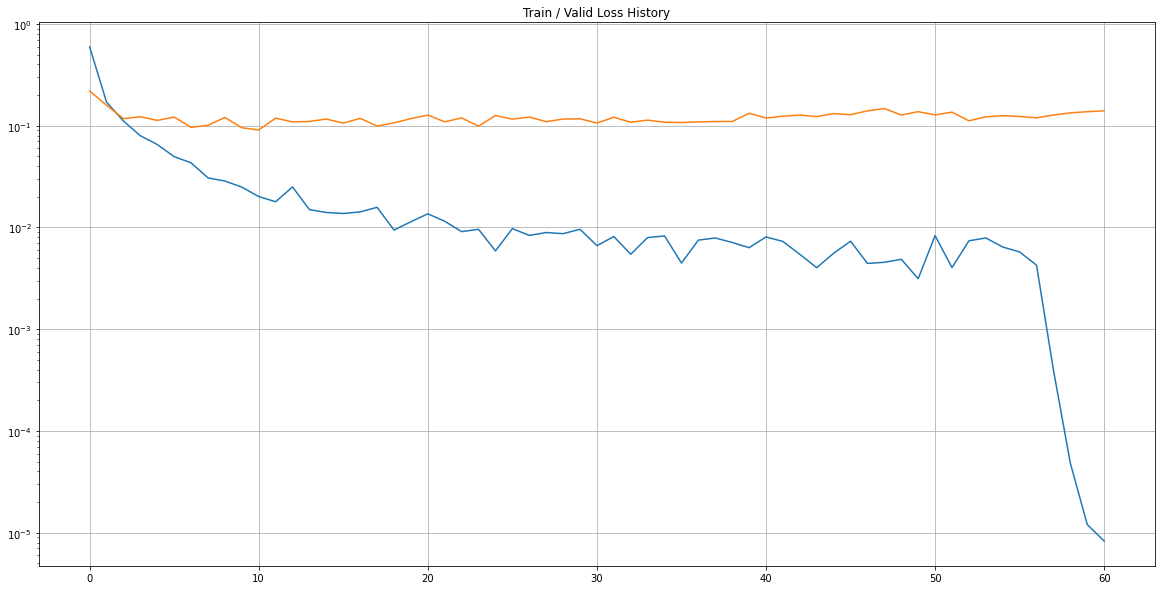

In [19]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Let's see the result!

In [20]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Validation loss: %.4e" % test_loss)

Validation loss: 9.1079e-02


In [21]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum() # one-hot vector의 index를 가지고 있는 상태
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9799


confusion matrix를 통해 각 class별 성능을 파악하고, 대처할 수 있음!

In [22]:
# confusion matrix : 오차행렬
import pandas as pd
from sklearn.metrics import confusion_matrix 

In [23]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

# 2와 7 서로가 헷갈려한다는 것을 알 수 있음 -> 2와 7를 더 보강해야함!..

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,970,0,1,1,0,1,2,1,2,2
true_1,0,1123,4,0,0,0,2,2,4,0
true_2,1,2,1018,3,0,0,1,4,3,0
true_3,0,2,1,998,0,1,0,5,2,1
true_4,0,0,4,0,954,0,9,3,3,9
true_5,2,0,0,18,1,857,7,1,3,3
true_6,3,2,0,1,2,3,945,1,1,0
true_7,1,1,12,2,0,0,0,1001,4,7
true_8,2,0,3,7,0,7,4,3,945,3
true_9,1,2,0,2,5,3,1,5,2,988
